In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from datetime import timedelta

DATA_DIR = Path("data") # Directory dei dati
FILE_CSV = Path(DATA_DIR, "Dati_fessurimetri_temperatura_precipitazione_intero.csv") # Percorso del file CSV

Il seguente algoritmo per la previsione di eventi di slope failure tramite dati fessurimetrici prende come fondamente teoriche il metodo INV (Inverse Velocity Method) proposto da Fukuzono (1985) prima empiricamente, poi analiticamente da Voight (1988). Il principio cardine è che, durante la fase di creep terziario (accelerazione pre-collasso), l'inverso della velocità di spostamento (1/v) tende a zero in modo lineare col passare del tempo.L'applicazione di questo criterio possiede tuttavia delle problematiche risultando troppo ottimistico nella previsione della data di crollo, soprattutto nel caso di frane in materiale roccioso, qui si inserisce l'articolo "An improvement velocity inverse method for predicting the slope imminent failure time" di Qi, Cao & Peng (2023) dove si illustra un INV modificato attraverso un coefficiente correttivo C. 
Il metodo classico di Fukuzono presuppone che la velocità inversa decresca in modo perfettamente lineare fino a zero. Nella realtà, però, le frane mostrano spesso un'accelerazione finale molto più brusca di quella prevista da una retta. La previsione sarà sempre tardiva rispetto all'evento, il tempo reale sarà quindi una frazione del tempo calcolato con la regressione lineare. Viene consigliato un intervallo basato su indagini statistiche di eventi storici compreso tra 0.30 e 0.55, il valore standard è perciò 0.45.
Una ulteriore componente dell'algoritmo qui presentato è l'angolo alpha ovvero l'angolo tangente descritto da Zhou, Liu e Xu (2020) nell'articolo "A modiﬁed inverse-velocity method for predicting the failure time of landslides" e introdotto dalla trattazione teorica di Voight (1988). L'angolo tangente è calcolato non sulla velocità assoluta ma sul rapporto tra velocità attuale e velocità di riferimento (V_STAZIONARIA) ovvero la velocità di creep secondario, la frana viene normalizzata e si evidenzia il rapporto di accelerazione. L'angolo definisce tre soglie di allerta ponendo la fase di emergenza a 85°, fase che risulta la più ottimale per l'appplicazione del metodo di Fukuzono.

In [2]:
# 1. VARIABILI SCRIPT

DATA_INIZIO_ANALISI = '2025-11-09 00:00:00'

# Nomi Colonne (Copiati dalla tua struttura dati)
COL_VELOCITA = 'Lanzada Frana Fessurimetro F1 - Delta 1h [mm]'  # Cambia F1 con F2, F3, F4
COL_PIOGGIA = 'LANZADA Campo Franscia Precipitazione - Dato Grezzo [mm]'    # Dato stazione ARPA Campo Franscia
COL_TEMP = 'Lanzada Frana Temperatura roccia TR1 - Dato Grezzo [øC]'    # Dato studio geologico

# Quale metodo di Smoothing vuoi utilizzare? 1 - Savitsky-Golay 2 - Media Mobile
SMOOTHING_TECHNIQUE = 2

# Parametri di Smoothing (Savitzky-Golay)
SAVGOL_WINDOW = 25  # Lunghezza finestra filtro, 2n+1 da 11 a 51 aumenta se il grafico è troppo "nervoso" (spike), diminuisci se vuoi più reattività.
SAVGOL_POLY = 2 # Ordine del polinomio (2 o 3 è standard).
# Parametri di Smoothing (Media Mobile)
FINESTRA_SMOOTHING = 12 # Numero di campioni per la media mobile

# Parametri Fisici e di Allerta
V_STAZIONARIA = 0.02    # Velocità di riferimento (mm/h) per calcolo angolo tangente. Serve per l'angolo α. Se l'angolo è sempre >80° alza questo valore.
SOGLIA_FIT_ALPHA = 80.0 # Gradi: inizia a calcolare la previsione solo sopra questa soglia (minimo 80°).

# Fattore Correttivo (Metodo Qi et al., 2023)
# Riduce il tempo previsto linearmente perché la frana accelera esponenzialmente alla fine.
# Il valore suggerito da Qi et al. è compreso tra 0.30 e 0.55. Il metodo fukuzono classico corrispone ad un C=1.
# Una roccia più fragile come il caso di lanzada richiede un fattore più basso rispetto ad un terreno.
CORR_FACTOR = 0.45

In [3]:
# 2. ENUNCIAZIONE FUNZIONI

# A. Caricamento e Pulizia Dati
# La funzione processa_dataset carica il csv nel dataframe df tramite la libreria pandas (pd) e regola le variabili temporali
def processa_dataset(file_path, start_date):
    # L'encoding non è utf-8 ma latin1 nel caso del csv fornito dallo studio geologico
    df = pd.read_csv(file_path, encoding='latin1')
    
    # Conversione Data, necessaria per convertire il valore della cella Data del csv da stringa a timestamp
    # errors='coerce' applica NaT alle celle con valori errati eliminandole
    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
    
    # Il filtro temporale elimina le righe antecedenti la data decisa per l'analisi, 
    # sort_values le pone in ordine cronologico e reset_index fa ripartire l'indice in caso di righe eliminate
    df = df[df['Data'] >= start_date].sort_values('Data').reset_index(drop=True)
    
    # Calcolo tempo trascorso in ore (utile per la regressione)
    # t_start identifica la prima lettura temporale che viene succesivamente sottratta ad ogni valore temporale
    # essendo il valore in secondi si divide per 3600.0 per ottenere i secondi di ogni misura a partire dallo zero prefissato
    # la funzione di regressione lineare di Fukuzono ha bisogno di uno zero a partenza
    t_start = df['Data'].iloc[0]
    df['hours_elapsed'] = (df['Data'] - t_start).dt.total_seconds() / 3600.0
    
    return df
# B. INV Fukuzono
# La funzione applica la funzione savgol, calcola velocità inversa, angolo tangente e la previsione
def applica_fukuzono_qi(df, col_vel):
    # fillna(0) serve perché il filtro non accetta NaN
    v_clean = df[col_vel].fillna(0)
    # Creazione nome per titolo grafico
    smoothing_name = "Filtro non assegnato"
    if SMOOTHING_TECHNIQUE == 1:
        # 1. Smoothing con Savitzky-Golay (funzione della libreria scipy.signal)
        df['v_smooth'] = savgol_filter(v_clean, window_length=SAVGOL_WINDOW, polyorder=SAVGOL_POLY)
        smoothing_name = "Filtro SG"
    elif SMOOTHING_TECHNIQUE  == 2:
        df['v_smooth'] = v_clean.rolling(window=FINESTRA_SMOOTHING).mean()
        smoothing_name = "Media Pesata"
    else:
        print("Scegli un filtro tra Savitsky-Golay o Media Pesata")
    # Rimuoviamo valori negativi o nulli (fisicamente impossibili o fermi) per 1/V la soglia viene posta a 0.001 mm
    # Usiamo una copia per non corrompere l'indice
    df_calc = df[df['v_smooth'] > 0.001].copy()
    
    # 2. Calcolo Velocità Inversa (1/V)
    df_calc['inv_v'] = 1.0 / df_calc['v_smooth']
    
    # 3. Calcolo Angolo Tangente (Alpha)
    # Modello descritto da Qi et al. l'angolo Alpha quantifica la ripidità dell'accelerazione
    # Formula: arctan(V_corrente / V_stazionaria) convertita in gradi
    df_calc['alpha'] = np.degrees(np.arctan(df_calc['v_smooth'] / V_STAZIONARIA))
    
    # 4. Identificazione Fase di Accelerazione per il Fitting
    # La variabile SOGLIA_FIT_ALPHA è dichiarata dall'utente
    mask_fit = (df_calc['alpha'] >= SOGLIA_FIT_ALPHA)
    df_fit = df_calc[mask_fit]
    
    # Dichiarazione variabili per la predizione
    prediction_info = None
    model = None
    
    # Eseguiamo la regressione solo se abbiamo abbastanza punti in zona critica (>10 punti)
    # ovvero abbiamo abbastanza punti che soddisfino il valore minimo di angolo dichiarato in SOGLIA_FIT_ALPHA
    if len(df_fit) > 10:
        X = df_fit['hours_elapsed'].values.reshape(-1, 1)
        y = df_fit['inv_v'].values
        
        # Il codice modella i punti (tempo,1/V) come una retta (y=mx+q).
        model = LinearRegression()
        model.fit(X, y)
        
        # Se la pendenza (coef_) è negativa, la velocità inversa sta scendendo, ci si avvicina al crollo e la funzione di previsione di attiva
        # nel grafico si nota il punto di flesso antecedente al crollo
        if model.coef_[0] < 0:
            # Calcolo intersezione asse X (1/V = 0)
            t_zero_hours = -model.intercept_ / model.coef_[0]
            
            # Calcolo orario data base
            t_start_date = df['Data'].iloc[0]
            t_linear_date = t_start_date + timedelta(hours=t_zero_hours)
            
            # Applicazione coefficiente correttivo secondo Qi et al.
            last_observed_date = df_calc['Data'].iloc[-1]
            #Calcola quante ore mancano al crollo secondo la retta calcolata con Fukuzono
            hours_remaining_linear = t_zero_hours - df_calc['hours_elapsed'].iloc[-1]
            
            if hours_remaining_linear > 0:
                # Moltiplica il tempo rimanente per il coefficiente di correzione dichiarato
                hours_corrected = hours_remaining_linear * CORR_FACTOR
                # Enuncia la predizione corretta e crea un dizionario con tutte le date calcolate in funzione
                t_final_prediction = last_observed_date + timedelta(hours=hours_corrected)
                
                prediction_info = {
                    't_linear': t_linear_date,
                    't_corrected': t_final_prediction,
                    'slope': model.coef_[0],
                    'intercept': model.intercept_
                }
    # La funzione ritorna il dataframe pandas con tutte le colonne calcolate, il dizionario con le date di previsione
    return df_calc, prediction_info, df_fit, smoothing_name
    # il dataframe con i soli punti utilizzati per il calcolo della previsione (alpha>80) e il nome del filtro

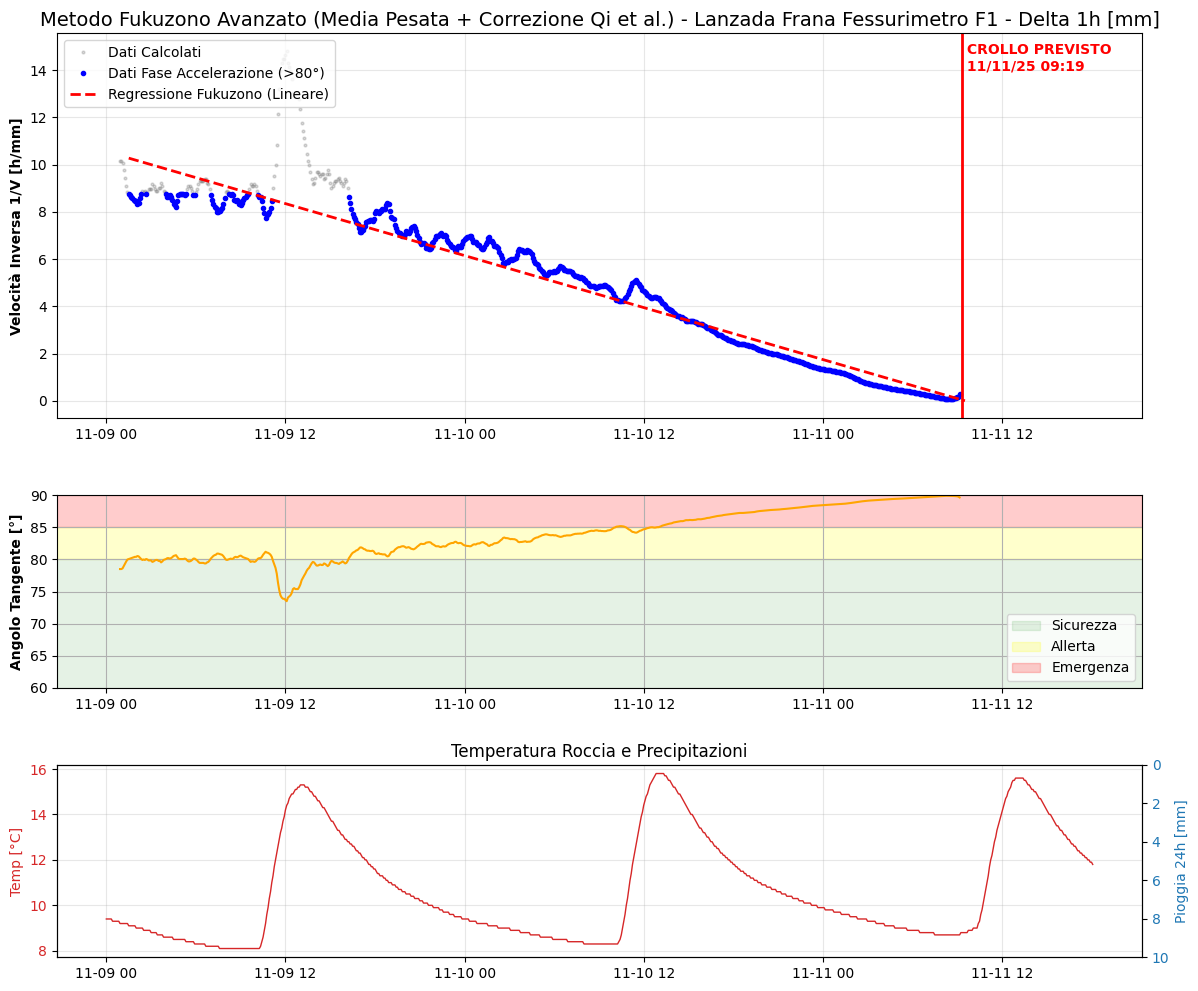

--------------------------------------------------
REPORT ANALISI PREVISIONALE
--------------------------------------------------
Data Ultimo Dato Disponibile:11-11-2025 09:10:00
Previsione Lineare (Fukuzono):11-11-2025 09:31:23
Previsione Corretta (Fattore 0.45):11-11-2025 09:19:37
Differenza tra previsione e crollo effettivo:0 days 00:09:37


In [4]:
# ESECUZIONE E PRODUZIONE GRAFICI

# Funzione di caricamento file csv
df_main = processa_dataset(FILE_CSV, DATA_INIZIO_ANALISI)

# BFunzione di analisi tramite fukuzono e metodo proposto da Qi et al.
df_res, prev, df_fit_used, filter_name = applica_fukuzono_qi(df_main, COL_VELOCITA)

# Creazione base grafico
fig = plt.figure(figsize=(14, 12))
# Divide la tela del grafico in tre righe e 1 colonna, imposta i rapporti e hspace è la distanza in altezza tra i 3 grafici
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.3)

# =============================================================================
# GRAFICO 1: Velocità Inversa e Previsione
ax1 = fig.add_subplot(gs[0])
ax1.plot(df_res['Data'], df_res['inv_v'], 'o', markersize=2, color='gray', alpha=0.3, label='Dati Calcolati')
# Vengono evidenziati in blu i punti utilizzati per la previsione (alpha>80°)
# l'if previene l'errore in caso lo script non trovi punti adatti al calcolo nel range previsto
if not df_fit_used.empty:
    ax1.plot(df_fit_used['Data'], df_fit_used['inv_v'], '.', color='blue', label='Dati Fase Accelerazione (>80°)')

# Retta di previsione
if prev:
    # Creiamo una linea temporale estesa fino alla previsione
    t_future = prev['t_linear']
    x_range = np.linspace(df_fit_used['hours_elapsed'].min(), 
                          (t_future - df_main['Data'].iloc[0]).total_seconds()/3600, 10)
    y_pred = prev['slope'] * x_range + prev['intercept']
    
    # Convertiamo x_range in datetime per il plot
    x_dates = [df_main['Data'].iloc[0] + timedelta(hours=h) for h in x_range]
    
    ax1.plot(x_dates, y_pred, 'r--', linewidth=2, label='Regressione Fukuzono (Lineare)')
    
    # Retta verticale previsione crollo con data
    ax1.axvline(prev['t_corrected'], color='red', linewidth=2, linestyle='-')
    ax1.text(prev['t_corrected'], ax1.get_ylim()[1]*0.9, 
             f" CROLLO PREVISTO\n {prev['t_corrected'].strftime('%d/%m/%y %H:%M')}", 
             color='red', fontweight='bold')

# Formattazione grafico
ax1.set_ylabel('Velocità Inversa 1/V [h/mm]', fontweight='bold')
ax1.set_title(f'Metodo Fukuzono Avanzato ({filter_name} + Correzione Qi et al.) - {COL_VELOCITA}', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# =============================================================================
# GRAFICO 2: Angolo Tangente con fasce di allerta 
ax2 = fig.add_subplot(gs[1], sharex=ax1)
# Plot della variazione dell'angolo alpha
ax2.plot(df_res['Data'], df_res['alpha'], color='orange', linewidth=1.5)

# Fasce di allerta
ax2.axhspan(0, 80, color='green', alpha=0.1, label='Sicurezza')
ax2.axhspan(80, 85, color='yellow', alpha=0.2, label='Allerta')
ax2.axhspan(85, 90, color='red', alpha=0.2, label='Emergenza')

# Formattazione grafico
ax2.set_ylabel('Angolo Tangente [°]', fontweight='bold')
# Varia questo intervallo per un focus sulle fasce di allerta ed emergenza
ax2.set_ylim(60, 90)
ax2.legend(loc='lower right')
ax2.grid(True)

# =============================================================================
# GRAFICO 3: Contesto Ambientale temperatura roccia e precipitazioni
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Temperatura
color_temp = 'tab:red'
# Convertiamo in numeri i valori di temperatura per evitare errori di lettura e uso errors='coerce' per eliminare le celle non valide
temp_data = pd.to_numeric(df_main[COL_TEMP], errors='coerce')
ax3.plot(df_main['Data'], temp_data, color=color_temp, linewidth=1, label='Temperatura Roccia')
ax3.set_ylabel('Temp [°C]', color=color_temp)
ax3.tick_params(axis='y', labelcolor=color_temp)

# Pioggia
# .twinx crea un asse x gemello a destra del grafico ax3
ax3b = ax3.twinx()
color_rain = 'tab:blue'

# Applico alle celle NaN il valore 0 altrimenti matplotlib non riesce a creare gli estremi del plot
pioggia_clean = df_main[COL_PIOGGIA].fillna(0)

# Pioggia cumulata sulle 24h
# min_periods=1 garantisce che calcoli qualcosa anche all'inizio del file
pioggia_24 = pioggia_clean.rolling(window=288, min_periods=1).sum()

# Plot
ax3b.fill_between(df_main['Data'], pioggia_24, color=color_rain, alpha=0.3, label='Pioggia Cumulata 24h')
ax3b.set_ylabel('Pioggia 24h [mm]', color=color_rain)
ax3b.tick_params(axis='y', labelcolor=color_rain)

# Scala asse y, il valore massimo è il valore della cumulata nelle 24h
max_p = pioggia_24.max()

# Controllo di sicurezza: se max_p è ancora nan o 0
if pd.isna(max_p) or max_p == 0:
    ax3b.set_ylim(10, 0) # Scala di default
else:
    ax3b.set_ylim(max_p * 3, 0) # Scala dinamica (ax3 per lasciare spazio alla temperatura)

ax3.set_title('Temperatura Roccia e Precipitazioni')
ax3.grid(True, alpha=0.3)

# Fix per layout
'''
try:
    plt.tight_layout()
except:
    pass
'''
plt.show()

# Stampa Report Testuale
print("-" * 50)
print("REPORT ANALISI PREVISIONALE")
print("-" * 50)
if prev:
    # Formattazione date
    data_ultimo = df_res['Data'].iloc[-1].strftime('%d-%m-%Y %H:%M:%S')
    data_linear = prev['t_linear'].strftime('%d-%m-%Y %H:%M:%S')
    data_corr = prev['t_corrected'].strftime('%d-%m-%Y %H:%M:%S')
    
    # Per la differenza di tempo, usiamo la divisione intera per togliere i microsecondi
    anticipo = prev['t_corrected'] - df_res['Data'].iloc[-1]
    # Trasformiamo in stringa e tagliamo i decimali
    durata_str = str(anticipo).split(".")[0] 

    print(f"Data Ultimo Dato Disponibile:{data_ultimo}")
    print(f"Previsione Lineare (Fukuzono):{data_linear}")
    print(f"Previsione Corretta (Fattore {CORR_FACTOR}):{data_corr}")
    print(f"Differenza tra previsione e crollo effettivo:{durata_str}")
else:
    print("Non è stato possibile calcolare una previsione.")
    print(f"Motivo: L'angolo tangente non ha superato la soglia di {SOGLIA_FIT_ALPHA}°.")
    print(f"Massimo angolo rilevato: {df_res['alpha'].max():.2f}°")